# Sample Point Creation ESM
Selects random sample of ESM3 data

#### Dask import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37813")
client

Client Scheduler: tcp://127.0.0.1:37813 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 64.42 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = slice(0, 2000)
maskName = "OceanMaskVolcello2"
lastESMDecade = slice('2005-01','2014-12')

<br>

#### Importing Libaries

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Loading Data

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]

zstore = dfFilt.zstore.values[0] #Opens first file only
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)

startDateIterate = np.datetime64(fileRaw['time'].values[0],'M')
endDateIterate = np.datetime64(fileRaw['time'].values[-1],'M') + np.timedelta64(1,'M')
fileRaw['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
fileRaw['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 

dfESMLat = fileRaw.thetao.sel(lat=latSel) #Selection of latitude
#dfESMLatLev = dfESMLat
dfESMLatLev = dfESMLat.sel(lev=levSel) #Selects level data down to 2k
dfESMLatLevT = dfESMLatLev.sel(time=lastESMDecade)
dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM3 data loaded and stored in dfESMLatLevT")
#dfESMLatLev #Uncomment to see data set

ESM3 data loaded and stored in dfESMLatLevT


In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask data loaded into oceanMask.")

Mask data loaded into oceanMask.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
</ul>

In [6]:
def pickRand(dataFrame, sampleNumbers):
    timeLen = len(dataFrame.time)
    latLen = len(dataFrame.lat)
    lonLen = len(dataFrame.lon)
    frameSize = timeLen*latLen*lonLen
    
    latRange = np.arange(-89.5, -29.4, 1)
    lonRange = np.arange(0.5, 359.6, 1)
    timeRange = np.arange(np.datetime64(globalStartDateStr), np.datetime64(globalEndDateOutStr))#, np.timedelta64(1, 'M'))
    
    sample = dataFrame.copy()
    if frameSize <= sampleNumbers: #More or equal samples are asked for than exist in the dataFrame
        print("Sample number is equal to or exceeds size of data frame, returning "+str(frameLen)+" data points.")
        return dataFrame
    else:
        dataArray = np.empty(shape=(0,4))
        sampleIDArray = np.empty(shape=(0))
        count = 0
        while(count < sampleNumbers):
            latID = np.random.choice(latRange)
            lonID = np.random.choice(lonRange)
            if any(np.isnan(oceanMask.sel(lat=latID,lon=lonID).values)): #Compares lat and lon to mask and checks for Nan
                #print("Bad location: Lat "+str(latID)+"  Lon "+str(lonID))
                continue
            else:
                timeID = np.random.choice(timeRange)
                #sampleID = str(abs(latID))+"_"+str(lonID)+"_"+str(timeID)
                sampleData = sample.sel(lat=latID, lon=lonID, time=timeID)
                #second Nan check?
                sampleArray = np.array([latID, lonID, np.datetime64(timeID, 'M'),sampleData.values], dtype=object)
                dataArray = np.append(dataArray, [sampleArray], axis=0)
                #sampleIDArray = np.append(sampleIDArray, sampleID)
                count += 1
    #exitArray = np.array([sampleIDArray])
    #print(exitArray)
    return dataArray
    
    
def pickRand2(dataFrame, sampleNumbers):
    timeLen = len(dataFrame.time)
    latLen = len(dataFrame.lat)
    lonLen = len(dataFrame.lon)
    frameSize = timeLen*latLen*lonLen
    
    geoLookup = 1 #import mask and calculate, perform out of function format [[lat1,lon1],[lat2,lon2]]
    timeRange = np.arange(np.datetime64(dataFrame.time[0]), np.datetime64(dataFrame.time[-1]))#, np.timedelta64(1, 'M'))
    
    print(timeRange)
    
    sample = dataFrame.copy()
    if frameSize <= sampleNumbers: #More or equal samples are asked for than exist in the dataFrame
        print("Sample number is equal to or exceeds size of data frame, returning "+str(frameLen)+" data points.")
        return dataFrame
    else:
        dataArray = np.empty(shape=(0,4)) #Empty export array
        
        geoID = np.random.choice(geoRange, sampleNumbers, False) #Select random samples
        
        for i in range(sampleNumbers):
            latID = geoLookup[geoID[i]][0]
            lonID = geoLookup[geoID[i]][1]
            timeID = '2005-01' #fsadkl;fjksl;adjf
            sampleData = sample.sel(lat=latID, lon=lonID, time=timeID)
            #second Nan check?
            sampleArray = np.array([latID, lonID, np.datetime64(timeID, 'M'),sampleData.values], dtype=object)
            dataArray = np.append(dataArray, [sampleArray], axis=0)
    return dataArray


print("Calculation functions defined")

Calculation functions defined


In [53]:
geoRange = np.empty(shape=(0,2))
for i in range(61):
    for j in range(360):
        if not np.isnan(oceanMask[0][i][j]):
            geoRange = np.append(geoRange, [[oceanMask.lat[i], oceanMask.lon[j]]], axis = 0)

In [110]:
geoRange[-1]

array([-29.5, 359.5])

In [88]:
geoRangeLat = np.empty(shape=(0))
geoRangeLon = np.empty(shape=(0))
for i in range(61):
    for j in range(360):
        if not np.isnan(oceanMask[0][i][j]):
            geoRangeLat = np.append(geoRangeLat, oceanMask.lat[i])
            geoRangeLon = np.append(geoRangeLon, oceanMask.lon[j])

In [104]:
geoRange2 = np.append([geoRangeLat], [geoRangeLon], axis = 0)

In [106]:
geoRange2

array([[-78.5, -78.5, -78.5, ..., -29.5, -29.5, -29.5],
       [165.5, 180.5, 181.5, ..., 357.5, 358.5, 359.5]])

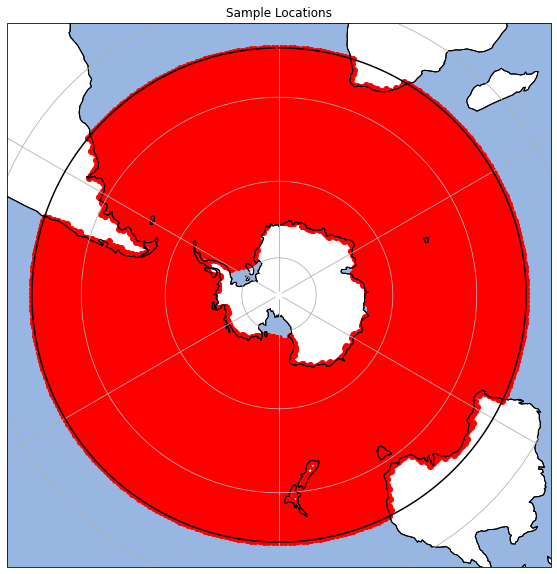

In [113]:
locationPlot2(geoRange2, (10, 10), 1)

<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>locationPlot - Plots locations of an input data set on a map.
<li>latDistribution - Plots latitude distribution of an input data set as a histogram.
<li>latDistributionCompare - Plots latitude distribution of two input data sets against each other as histograms.
<li>lonDistribution - Plots longitude distribution of an input data set as a histogram.
<li>lonDistributionCompare - Plots longitude distribution of two input data sets against each other as histograms.
</ul>

In [111]:
def locationPlot(dataSet, size, plotNo):
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    for i in range(len(dataSet)):
        plt.scatter(dataSet[i][1], dataSet[i][0], color="Red", transform=ccrs.PlateCarree(),cmap='RdBu_r')
    plt.plot(np.arange(0,360,1),np.ones(360)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations")
    
def locationPlot2(dataSet, size, plotNo):##########################
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    plt.scatter(dataSet[1], dataSet[0], color="Red", transform=ccrs.PlateCarree(),cmap='RdBu_r')
    plt.plot(np.arange(0,360,1),np.ones(360)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations")
    
def latDistribution(dataSet, plotNo):
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, 2.5)
    plt.hist(dataSet[:][0], bins = latDistri)
    plt.title("Latitude distribution of data points")
    
def latDistributionCompare(dataSet1, dataSet2, plotNo):
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, 2.5)
    latWeights1 = np.ones_like(dataSet1["Lat"])/float(len(dataSet1["Lat"]))
    latWeights2 = np.ones_like(dataSet2["Lat"])/float(len(dataSet2["Lat"]))
    plt.hist(dataSet1["Lat"], bins = latDistri, weights = latWeights1, alpha=0.5, label=dataSet1.name)
    plt.hist(dataSet2["Lat"], bins = latDistri, weights = latWeights2, alpha=0.5, label=dataSet2.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Latitude distribution of data points compared to main data set")
    
def lonDistribution(dataSet, plotNo):
    plt.figure(plotNo)
    lonDistri = np.arange(np.datet, 180, 10)
    plt.hist(dataSet["Lon"], bins = lonDistri)
    plt.title("Longitude distribution of data points")
    
def lonDistributionCompare(dataSet1, dataSet2, plotNo):
    plt.figure(plotNo)
    lonDistri = np.arange(-180, 180, 10)
    lonWeights1 = np.ones_like(dataSet1["Lon"])/float(len(dataSet1["Lon"]))
    lonWeights2 = np.ones_like(dataSet2["Lon"])/float(len(dataSet2["Lon"]))
    plt.hist(dataSet1["Lon"], bins = lonDistri, weights = lonWeights1, alpha=0.5, label=dataSet1.name)
    plt.hist(dataSet2["Lon"], bins = lonDistri, weights = lonWeights2, alpha=0.5, label=dataSet2.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to main data set")
    
def timeDistribution(dataSet, plotNo):
    plt.figure(plotNo)
    timeDistri = np.arange(globalStartDate, globalEndDateOut, globalDateInc)
    plt.hist(dataSet["time"], bins = timeDistri)
    plt.title("Time distribution of data points")
    
def lonDistributionCompare(dataSet1, dataSet2, plotNo):
    plt.figure(plotNo)
    timeDistri = np.arange(globalStartDate, globalEndDateOut, globalDateInc)
    timeWeights1 = np.ones_like(dataSet1["time"])/float(len(dataSet1["time"]))
    timeWeights2 = np.ones_like(dataSet2["time"])/float(len(dataSet2["time"]))
    plt.hist(dataSet1["time"], bins = timeDistri, weights = lonWeights1, alpha=0.5, label=dataSet1.name)
    plt.hist(dataSet2["time"], bins = timeDistri, weights = lonWeights2, alpha=0.5, label=dataSet2.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to main data set")
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Displaying of data
<b>Demonstration of random sampling - 10 small scale samples</b>

In [40]:
randomDataPointsList = []
for i in range(10):
    randomDataPoints = pickRand(dfESMLatLevT, 5)
    randomDataPointsList.append(randomDataPoints)
    locationPlot(randomDataPoints, (5,5), i)

KeyboardInterrupt: 

<br>
<b>Large Random Sample</b>

In [ ]:
sampleDataPoints = pickRand(dfESMLatLevT, 1000)
locationPlot(sampleDataPoints, (10,10), 1)

<br>
<b>Latitude and Longitude distribution of large sample</b>

In [ ]:
latDistribution(sampleFloatLocations, 1)
lonDistribution(sampleFloatLocations, 2)

<br>
<b>Latitude and Longitude distribution of large sample, compared to distributions of original data set</b>

In [ ]:
latDistributionCompare(sampleFloatLocations, dfFloatLoc, 1)
lonDistributionCompare(sampleFloatLocations, dfFloatLoc, 2)